In [2]:
!pip install tensorflow_addons

In [4]:
# Install TensorFlow 2.13 and TensorFlow Addons 0.20.0 for compatibility
!pip install tensorflow==2.11 tensorflow-addons==0.19.0

In [5]:
import tensorflow as tf
import tensorflow_addons as tfa

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import tensorflow_addons as tfa


In [8]:
import zipfile
import pandas as pd
import os

# Extract files from the zip
with zipfile.ZipFile('/content/sleep actigraphy.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

# Process each file
for file_name in os.listdir('extracted_files'):
    if file_name.endswith('.csv'):  # Adjust extension if files are not CSV
        try:
            df = pd.read_csv(f'extracted_files/{file_name}')
            df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors to NaN
            print(df.head())  # Debug by inspecting data
        except Exception as e:
            print(f"Error in file {file_name}: {e}")

   timestamp  date  linetime  activity  label
0        NaN   NaN       NaN      63.0      2
1        NaN   NaN       NaN      81.0      2
2        NaN   NaN       NaN      81.0      2
3        NaN   NaN       NaN      89.0      2
4        NaN   NaN       NaN      93.0      2
   timestamp  date  linetime  activity  label
0        NaN   NaN       NaN       6.0      2
1        NaN   NaN       NaN      46.0      2
2        NaN   NaN       NaN       1.0      2
3        NaN   NaN       NaN       0.0      2
4        NaN   NaN       NaN      39.0      2
   timestamp  date  linetime  activity  label
0        NaN   NaN       NaN     119.0      1
1        NaN   NaN       NaN      48.0      1
2        NaN   NaN       NaN     115.0      1
3        NaN   NaN       NaN     152.0      1
4        NaN   NaN       NaN     268.0      1
   timestamp  date  linetime  activity  label
0        NaN   NaN       NaN     223.0      3
1        NaN   NaN       NaN     120.0      3
2        NaN   NaN       NaN      

In [9]:
def load_dataset(file_path, feature_columns, target_columns, sequence_length=100):
    # Read dataset
    data = pd.read_csv('/content/sleep actigraphy.zip')

    # Extract features (X) and targets (y)
    X = data[feature_columns].values
    y = data[target_columns].values

    # Reshape X to 3D for LSTM models [samples, time_steps, features]
    num_samples = X.shape[0] // sequence_length
    X = X[:num_samples * sequence_length].reshape((num_samples, sequence_length, len(feature_columns)))
    y = y[:num_samples]

    return X, y

In [10]:
# Get dataset path and columns
file_path = input("Enter the path (Zip-format):")
feature_columns = ['timestamp', 'date', 'linetime']  # Replace with actual feature columns
target_columns = ['activity', 'label']  # Replace with actual target columns



Enter the path (Zip-format):/content/sleep actigraphy.zip


In [ ]:
import pandas as pd
import zipfile
import numpy as np

def load_dataset(file_path, feature_columns, target_columns, sequence_length=100):
       # Initialize an empty list to store DataFrames
       all_data = []

       # Open the zip file
       with zipfile.ZipFile(file_path, 'r') as zip_ref:
           # Iterate through all files in the zip file
           for file_name in zip_ref.namelist():
               # Check if the file is a CSV file
               if file_name.endswith('.csv'):
                   # Open the CSV file within the zip file
                   with zip_ref.open(file_name) as file:
                       # Read the CSV file into a DataFrame
                       data = pd.read_csv(file)

                       # Check if target columns exist in the DataFrame
                       # If not, skip this file and print a warning message
                       if not all(col in data.columns for col in target_columns):
                           print(f"Warning: File '{file_name}' is missing target columns. Skipping...")
                           continue

                       # Check if feature columns exist in the DataFrame
                       # If not, skip this file and print a warning message
                       if not all(col in data.columns for col in feature_columns):
                           print(f"Warning: File '{file_name}' is missing feature columns. Skipping...")
                           continue

                       # Convert linetime to seconds since the start of the day
                       data['linetime'] = pd.to_datetime(data['linetime']).dt.hour * 3600 + \
                                         pd.to_datetime(data['linetime']).dt.minute * 60 + \
                                         pd.to_datetime(data['linetime']).dt.second

                       # Extract features (X) and targets (y) (drop timestamp and date)
                       X = data[['linetime']].values  # Keep only 'linetime' as feature
                       y = data[target_columns].values

                       # Reshape X to 3D for LSTM models [samples, time_steps, features]
                       num_samples = X.shape[0] // sequence_length
                       X = X[:num_samples * sequence_length].reshape((num_samples, sequence_length, 1)) # 1 feature
                       y = y[:num_samples]

                       # Append the DataFrame to the list
                       all_data.append(pd.DataFrame({'X': list(X), 'y': list(y)}))

       # Concatenate all DataFrames into a single DataFrame
       # Check if all_data is empty (no valid CSV files found)
       if not all_data:
           raise ValueError("No valid CSV files found in the zip file with the specified columns.")

       final_df = pd.concat(all_data, ignore_index=True)

       # Extract features and targets from the final DataFrame
       X = np.array(final_df['X'].tolist())
       y = np.array(final_df['y'].tolist())

       return X, y

In [ ]:
X, y = load_dataset(file_path, feature_columns, target_columns)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-11-1374fdb93790>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['linetime'] = pd.to_datetime(data['linetime']).dt.hour * 3600 + \
<ipython-input-11-1374fdb93790>:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(data['linetime']).dt.minute * 60 + \
<ipython-input-11-1374fdb93790>:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(data['linetime']).dt.second


<ipython-input-11-1374fdb93790>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['linetime'] = pd.to_datetime(data['linetime']).dt.hour * 3600 + \
<ipython-input-11-1374fdb93790>:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(data['linetime']).dt.minute * 60 + \
<ipython-input-11-1374fdb93790>:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(data['linetime']).dt.second
<ipython-input-11-1374fdb93790>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is c

In [ ]:
model_gru = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])

model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)


Epoch 1/10
127/127 [==============================] - 33s 222ms/step - loss: 2730.8765 - mae: 23.8516 - val_loss: 2440.1423 - val_mae: 25.1920
Epoch 2/10
127/127 [==============================] - 26s 203ms/step - loss: 2399.0427 - mae: 25.9418 - val_loss: 2438.9441 - val_mae: 25.6472
Epoch 3/10
127/127 [==============================] - 28s 221ms/step - loss: 2395.5063 - mae: 26.0913 - val_loss: 2438.4519 - val_mae: 25.5060
Epoch 4/10
127/127 [==============================] - 28s 220ms/step - loss: 2399.0576 - mae: 25.9582 - val_loss: 2438.7295 - val_mae: 25.4542
Epoch 5/10
127/127 [==============================] - 28s 220ms/step - loss: 2401.5667 - mae: 25.9896 - val_loss: 2438.5408 - val_mae: 25.5179
Epoch 6/10
127/127 [==============================] - 25s 199ms/step - loss: 2397.2878 - mae: 25.9763 - val_loss: 2439.9866 - val_mae: 25.7532
Epoch 7/10
127/127 [==============================] - 25s 199ms/step - loss: 2397.3015 - mae: 26.0931 - val_loss: 2442.4844 - val_mae: 25.2268

In [ ]:
# Define and Train CNN + LSTM Model
model_cnn_lstm = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])

model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)


Epoch 1/10
127/127 [==============================] - 9s 48ms/step - loss: 3073.0359 - mae: 23.2084 - val_loss: 2707.0835 - val_mae: 22.8371
Epoch 2/10
127/127 [==============================] - 7s 58ms/step - loss: 2523.3523 - mae: 24.0095 - val_loss: 2502.7104 - val_mae: 23.9011
Epoch 3/10
127/127 [==============================] - 6s 45ms/step - loss: 2419.2732 - mae: 25.0557 - val_loss: 2442.5098 - val_mae: 24.9462
Epoch 4/10
127/127 [==============================] - 7s 55ms/step - loss: 2421.8806 - mae: 25.3562 - val_loss: 2463.2336 - val_mae: 24.4433
Epoch 5/10
127/127 [==============================] - 6s 43ms/step - loss: 2414.7273 - mae: 25.7151 - val_loss: 2464.4558 - val_mae: 24.3896
Epoch 6/10
127/127 [==============================] - 6s 47ms/step - loss: 2416.4294 - mae: 25.6223 - val_loss: 2460.2253 - val_mae: 24.4557
Epoch 7/10
127/127 [==============================] - 6s 50ms/step - loss: 2454.8350 - mae: 25.3216 - val_loss: 2509.6895 - val_mae: 23.9104
Epoch 8/10
12

In [ ]:
from tensorflow.keras.layers import Input, LSTM, MultiHeadAttention, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)
attention_out = MultiHeadAttention(num_heads=2, key_dim=32)(lstm_out, lstm_out)
dropout = Dropout(0.2)(attention_out)
flatten = Flatten()(dropout)
dense = Dense(32, activation='relu')(flatten)
output = Dense(2, activation='linear')(dense)

model_attention_lstm = Model(inputs=input_layer, outputs=output)
model_attention_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_attention_lstm = model_attention_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)


Epoch 1/10
127/127 [==============================] - 19s 118ms/step - loss: 2463.9849 - mae: 26.2079 - val_loss: 2447.7214 - val_mae: 26.2065
Epoch 2/10
127/127 [==============================] - 14s 109ms/step - loss: 2420.9399 - mae: 26.1002 - val_loss: 2483.3159 - val_mae: 24.1815
Epoch 3/10
127/127 [==============================] - 15s 119ms/step - loss: 2406.6167 - mae: 25.9587 - val_loss: 2458.5754 - val_mae: 26.5453
Epoch 4/10
127/127 [==============================] - 15s 118ms/step - loss: 2404.6460 - mae: 26.0884 - val_loss: 2455.4565 - val_mae: 24.7662
Epoch 5/10
127/127 [==============================] - 14s 111ms/step - loss: 2406.5889 - mae: 25.9080 - val_loss: 2443.6282 - val_mae: 25.9325
Epoch 6/10
127/127 [==============================] - 14s 112ms/step - loss: 2406.8240 - mae: 26.1045 - val_loss: 2450.9424 - val_mae: 26.2890
Epoch 7/10
127/127 [==============================] - 14s 114ms/step - loss: 2414.3000 - mae: 26.0543 - val_loss: 2444.8535 - val_mae: 26.0084

In [ ]:
# Evaluate each model
loss_gru, mae_gru = model_gru.evaluate(X_test, y_test, verbose=1)
loss_cnn_lstm, mae_cnn_lstm = model_cnn_lstm.evaluate(X_test, y_test, verbose=1)
loss_attention, mae_attention = model_attention_lstm.evaluate(X_test, y_test, verbose=1)

print(f"GRU Model - Test Loss: {loss_gru}")
print(f"GRU Model - Test MAE: {mae_gru}")
print(f"CNN + LSTM Model - Test Loss: {loss_cnn_lstm}")
print(f"CNN + LSTM Model - Test MAE: {mae_cnn_lstm}")
print(f"Attention-based LSTM Model - Test Loss: {loss_attention}")
print(f"Attention-based LSTM Model - Test MAE: {mae_attention}")



32/32 [==============================] - 1s 33ms/step - loss: 2440.4316 - mae: 25.2857
GRU Model - Test Loss: 2442.345947265625
GRU Model - Test MAE: 25.732057571411133
CNN + LSTM Model - Test Loss: 2559.9814453125
CNN + LSTM Model - Test MAE: 23.442180633544922
Attention-based LSTM Model - Test Loss: 2440.431640625
Attention-based LSTM Model - Test MAE: 25.28569793701172


In [ ]:
# Predictions for each model
predictions_gru = model_gru.predict(X_test)
predictions_cnn_lstm = model_cnn_lstm.predict(X_test)
predictions_attention_lstm = model_attention_lstm.predict(X_test)



32/32 [==============================] - 2s 34ms/step


In [ ]:
# Calculate R2 scores for each model
r2_gru_sleep_qual = r2_score(y_test[:, 0], predictions_gru[:, 0])
r2_gru_sleep_cons = r2_score(y_test[:, 1], predictions_gru[:, 1])
r2_cnn_lstm_sleep_qual = r2_score(y_test[:, 0], predictions_cnn_lstm[:, 0])
r2_cnn_lstm_sleep_cons = r2_score(y_test[:, 1], predictions_cnn_lstm[:, 1])
r2_attention_sleep_qual = r2_score(y_test[:, 0], predictions_attention_lstm[:, 0])
r2_attention_sleep_cons = r2_score(y_test[:, 1], predictions_attention_lstm[:, 1])

print(f"GRU Model - R2 Score for SleepQualWeek: {r2_gru_sleep_qual}")
print(f"GRU Model - R2 Score for SleepCons: {r2_gru_sleep_cons}")
print(f"CNN + LSTM Model - R2 Score for SleepQualWeek: {r2_cnn_lstm_sleep_qual}")
print(f"CNN + LSTM Model - R2 Score for SleepCons: {r2_cnn_lstm_sleep_cons}")
print(f"Attention-based LSTM Model - R2 Score for SleepQualWeek: {r2_attention_sleep_qual}")
print(f"Attention-based LSTM Model - R2 Score for SleepCons: {r2_attention_sleep_cons}")



GRU Model - R2 Score for SleepQualWeek: -0.0015869469664913094
GRU Model - R2 Score for SleepCons: -0.0020188628944979303
CNN + LSTM Model - R2 Score for SleepQualWeek: -0.04981691907833086
CNN + LSTM Model - R2 Score for SleepCons: -0.13291909796818802
Attention-based LSTM Model - R2 Score for SleepQualWeek: -0.0007985534619188162
Attention-based LSTM Model - R2 Score for SleepCons: -0.025292140336486524


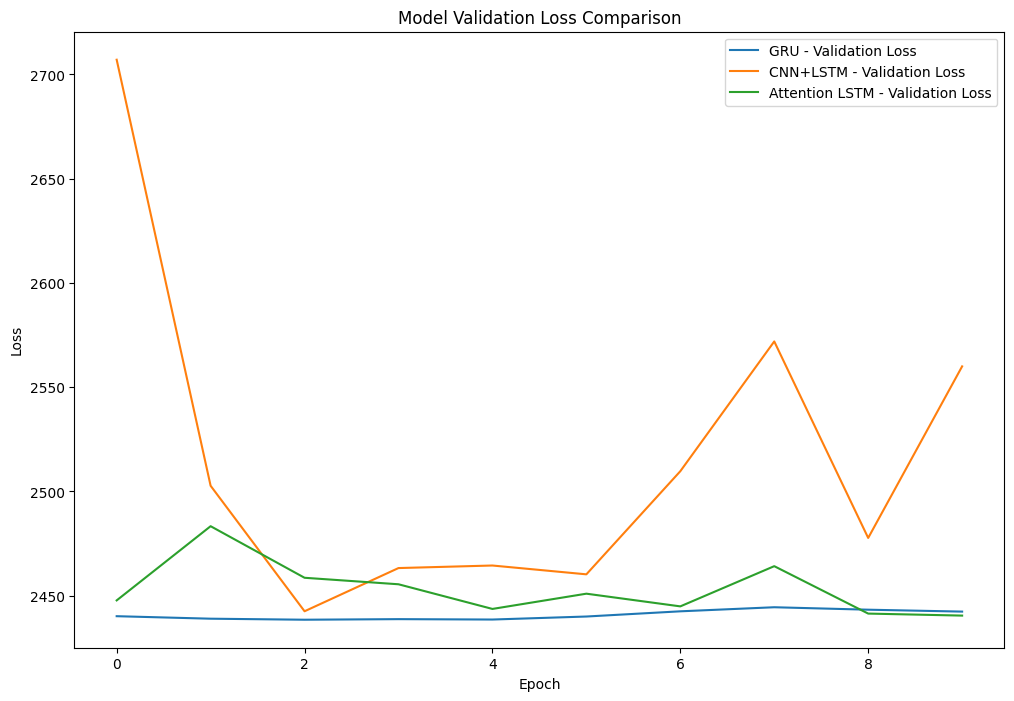

In [ ]:
# Plot training & validation loss values for each model
plt.figure(figsize=(12, 8))

#GRU
plt.plot(history_gru.history['val_loss'], label='GRU - Validation Loss')

# CNN + LSTM
plt.plot(history_cnn_lstm.history['val_loss'], label='CNN+LSTM - Validation Loss')
# Attention LSTM
plt.plot(history_attention_lstm.history['val_loss'], label='Attention LSTM - Validation Loss')

plt.title('Model Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

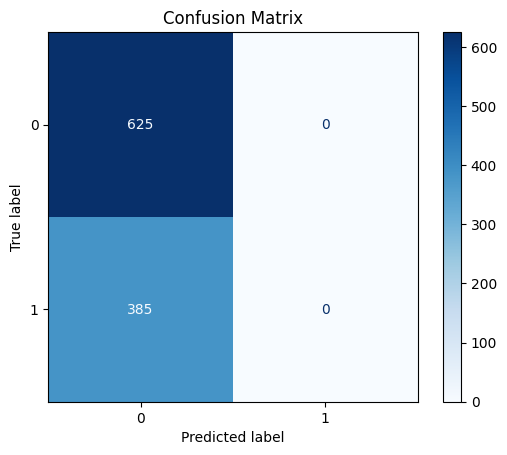

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assume 'y_test' from your previous code holds the true labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices if necessary

# Assume 'predictions_gru' from your previous code holds the model predictions
# You might need to select the appropriate model's predictions
y_pred = np.argmax(predictions_gru, axis=1)  # Convert predictions to class indices if necessary

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


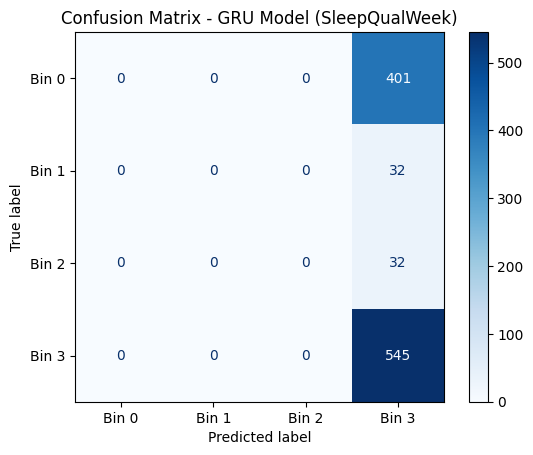

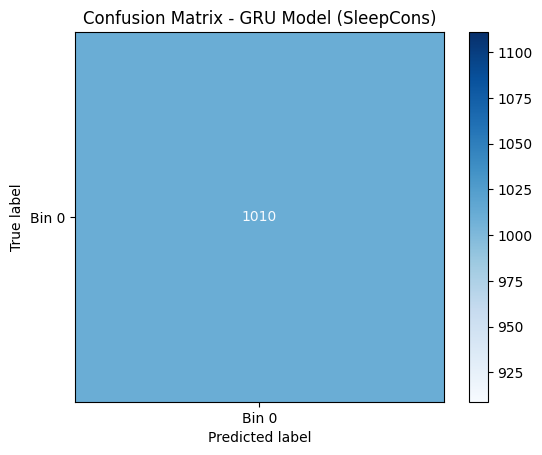

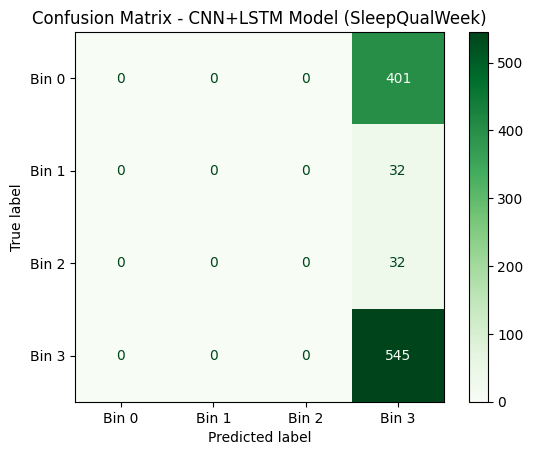

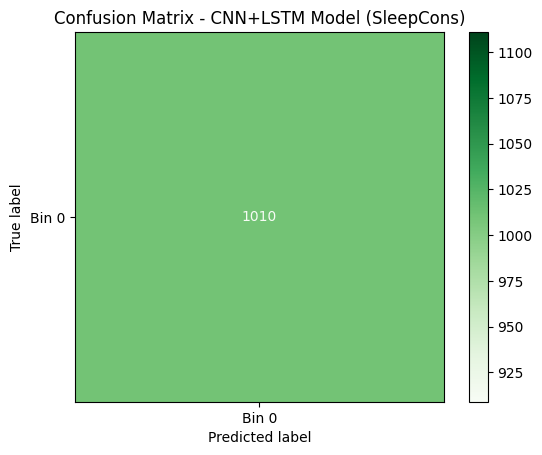

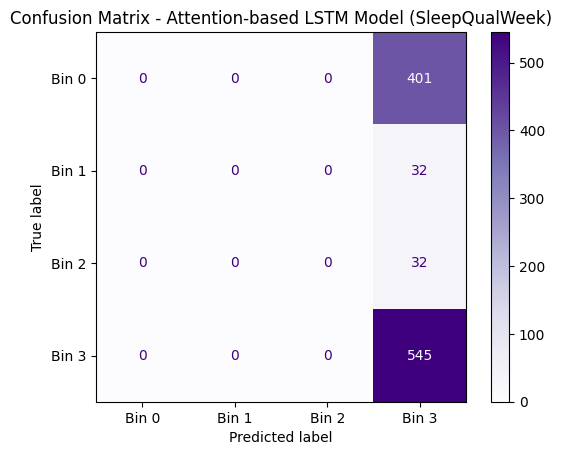

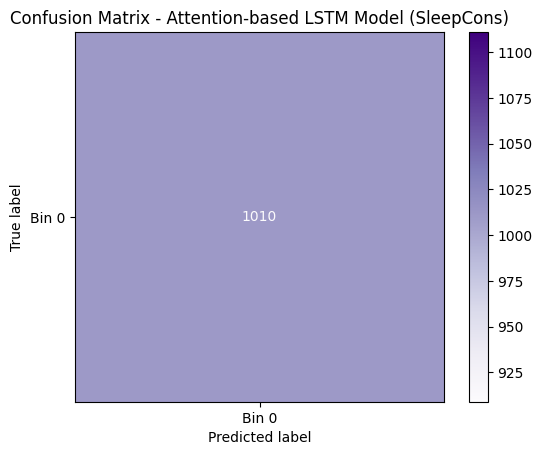

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define bins and labels for discretizing the outputs
def discretize_outputs(y, bins):
    return np.digitize(y, bins) - 1  # Adjust for 0-based indexing

# Define bins for SleepQualWeek and SleepCons
bins_sleep_qual = [0, 3, 6, 9]  # Example thresholds for SleepQualWeek
bins_sleep_cons = [0, 4, 8, 12]  # Example thresholds for SleepCons

# Discretize actual and predicted outputs for each model
y_test_qual_binned = discretize_outputs(y_test[:, 0], bins_sleep_qual)
y_test_cons_binned = discretize_outputs(y_test[:, 1], bins_sleep_cons)

pred_gru_qual_binned = discretize_outputs(predictions_gru[:, 0], bins_sleep_qual)
pred_gru_cons_binned = discretize_outputs(predictions_gru[:, 1], bins_sleep_cons)

pred_cnn_lstm_qual_binned = discretize_outputs(predictions_cnn_lstm[:, 0], bins_sleep_qual)
pred_cnn_lstm_cons_binned = discretize_outputs(predictions_cnn_lstm[:, 1], bins_sleep_cons)

pred_attention_qual_binned = discretize_outputs(predictions_attention_lstm[:, 0], bins_sleep_qual)
pred_attention_cons_binned = discretize_outputs(predictions_attention_lstm[:, 1], bins_sleep_cons)

# Compute confusion matrices for each model and target
cm_gru_qual = confusion_matrix(y_test_qual_binned, pred_gru_qual_binned)
cm_gru_cons = confusion_matrix(y_test_cons_binned, pred_gru_cons_binned)

cm_cnn_lstm_qual = confusion_matrix(y_test_qual_binned, pred_cnn_lstm_qual_binned)
cm_cnn_lstm_cons = confusion_matrix(y_test_cons_binned, pred_cnn_lstm_cons_binned)

cm_attention_qual = confusion_matrix(y_test_qual_binned, pred_attention_qual_binned)
cm_attention_cons = confusion_matrix(y_test_cons_binned, pred_attention_cons_binned)

# Plot confusion matrices for GRU model
# Use unique bin values for display labels (as you've already calculated)
ConfusionMatrixDisplay(cm_gru_qual, display_labels=[f"Bin {i}" for i in unique_bins_qual]).plot(cmap="Blues")
plt.title("Confusion Matrix - GRU Model (SleepQualWeek)")
plt.show()

ConfusionMatrixDisplay(cm_gru_cons, display_labels=[f"Bin {i}" for i in unique_bins_cons]).plot(cmap="Blues")
plt.title("Confusion Matrix - GRU Model (SleepCons)")
plt.show()

# Similarly, plot for CNN+LSTM
# Use unique bin values instead of the full range
ConfusionMatrixDisplay(cm_cnn_lstm_qual, display_labels=[f"Bin {i}" for i in unique_bins_qual]).plot(cmap="Greens")
plt.title("Confusion Matrix - CNN+LSTM Model (SleepQualWeek)")
plt.show()

# For SleepCons, since there's only one bin in cm_cnn_lstm_cons:
ConfusionMatrixDisplay(cm_cnn_lstm_cons, display_labels=[f"Bin {i}" for i in unique_bins_cons]).plot(cmap="Greens")
plt.title("Confusion Matrix - CNN+LSTM Model (SleepCons)")
plt.show()

# And for Attention-based LSTM
ConfusionMatrixDisplay(cm_attention_qual, display_labels=[f"Bin {i}" for i in unique_bins_qual]).plot(cmap="Purples")
plt.title("Confusion Matrix - Attention-based LSTM Model (SleepQualWeek)")
plt.show()

# For SleepCons, since there's only one bin in cm_attention_cons:
ConfusionMatrixDisplay(cm_attention_cons, display_labels=[f"Bin {i}" for i in unique_bins_cons]).plot(cmap="Purples")
plt.title("Confusion Matrix - Attention-based LSTM Model (SleepCons)")
plt.show()



GRU - SleepQualWeek - Accuracy: 0.54
GRU - SleepQualWeek - Classification Report:
              precision    recall  f1-score   support

       Bin 0       0.00      0.00      0.00       401
       Bin 1       0.00      0.00      0.00        32
       Bin 2       0.00      0.00      0.00        32
       Bin 3       0.54      1.00      0.70       545

    accuracy                           0.54      1010
   macro avg       0.13      0.25      0.18      1010
weighted avg       0.29      0.54      0.38      1010



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


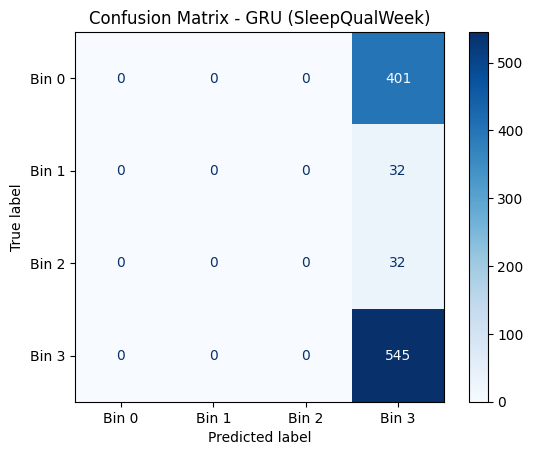

GRU - SleepCons - Accuracy: 1.00
GRU - SleepCons - Classification Report:
              precision    recall  f1-score   support

       Bin 0       1.00      1.00      1.00      1010

    accuracy                           1.00      1010
   macro avg       1.00      1.00      1.00      1010
weighted avg       1.00      1.00      1.00      1010



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


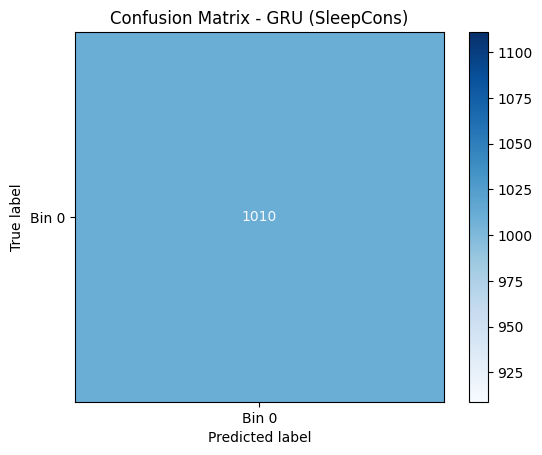

CNN+LSTM - SleepQualWeek - Accuracy: 0.54
CNN+LSTM - SleepQualWeek - Classification Report:
              precision    recall  f1-score   support

       Bin 0       0.00      0.00      0.00       401
       Bin 1       0.00      0.00      0.00        32
       Bin 2       0.00      0.00      0.00        32
       Bin 3       0.54      1.00      0.70       545

    accuracy                           0.54      1010
   macro avg       0.13      0.25      0.18      1010
weighted avg       0.29      0.54      0.38      1010



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


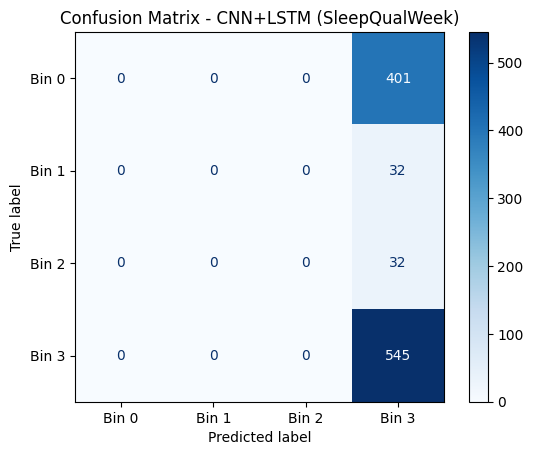

CNN+LSTM - SleepCons - Accuracy: 1.00
CNN+LSTM - SleepCons - Classification Report:
              precision    recall  f1-score   support

       Bin 0       1.00      1.00      1.00      1010

    accuracy                           1.00      1010
   macro avg       1.00      1.00      1.00      1010
weighted avg       1.00      1.00      1.00      1010



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


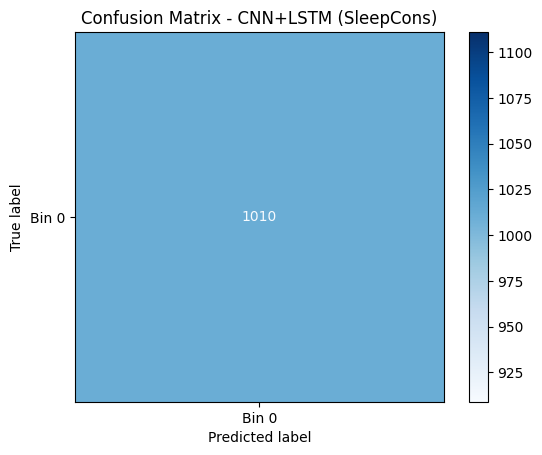

Attention-based LSTM - SleepQualWeek - Accuracy: 0.54
Attention-based LSTM - SleepQualWeek - Classification Report:
              precision    recall  f1-score   support

       Bin 0       0.00      0.00      0.00       401
       Bin 1       0.00      0.00      0.00        32
       Bin 2       0.00      0.00      0.00        32
       Bin 3       0.54      1.00      0.70       545

    accuracy                           0.54      1010
   macro avg       0.13      0.25      0.18      1010
weighted avg       0.29      0.54      0.38      1010



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


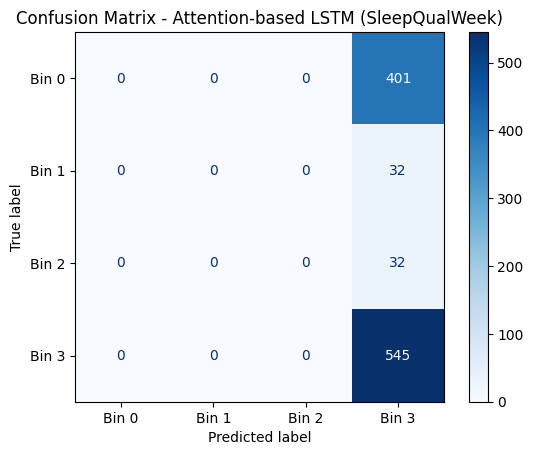

Attention-based LSTM - SleepCons - Accuracy: 1.00
Attention-based LSTM - SleepCons - Classification Report:
              precision    recall  f1-score   support

       Bin 0       1.00      1.00      1.00      1010

    accuracy                           1.00      1010
   macro avg       1.00      1.00      1.00      1010
weighted avg       1.00      1.00      1.00      1010



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


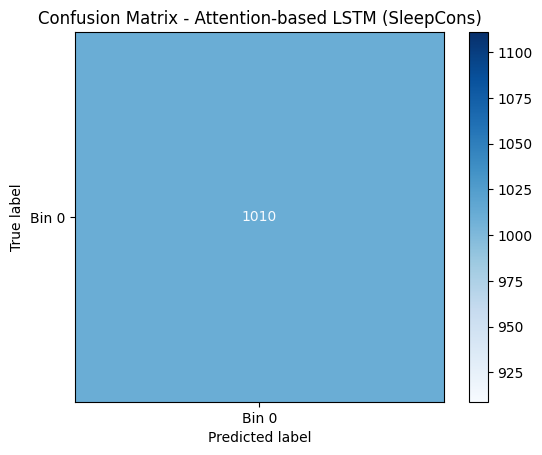

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(predictions, y_test_binned, bins, model_name, target_name):
    # Discretize predictions
    pred_binned = discretize_outputs(predictions, bins)

    # Accuracy
    accuracy = accuracy_score(y_test_binned, pred_binned)
    print(f"{model_name} - {target_name} - Accuracy: {accuracy:.2f}")

    # Get unique class labels
    unique_labels = np.unique(np.concatenate((y_test_binned, pred_binned)))

    # Classification Report
    # Use unique_labels to generate target_names to match the number of classes
    class_report = classification_report(y_test_binned, pred_binned, labels=unique_labels, target_names=[f"Bin {i}" for i in unique_labels])
    print(f"{model_name} - {target_name} - Classification Report:\n{class_report}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_binned, pred_binned)

    # Use unique labels for display
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Bin {i}" for i in unique_labels]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name} ({target_name})")
    plt.show()

# Evaluate GRU model
evaluate_model(predictions_gru[:, 0], y_test_qual_binned, bins_sleep_qual, "GRU", "SleepQualWeek")
evaluate_model(predictions_gru[:, 1], y_test_cons_binned, bins_sleep_cons, "GRU", "SleepCons")

# Evaluate CNN + LSTM model
evaluate_model(predictions_cnn_lstm[:, 0], y_test_qual_binned, bins_sleep_qual, "CNN+LSTM", "SleepQualWeek")
evaluate_model(predictions_cnn_lstm[:, 1], y_test_cons_binned, bins_sleep_cons, "CNN+LSTM", "SleepCons")

# Evaluate Attention-based LSTM model
evaluate_model(predictions_attention_lstm[:, 0], y_test_qual_binned, bins_sleep_qual, "Attention-based LSTM", "SleepQualWeek")
evaluate_model(predictions_attention_lstm[:, 1], y_test_cons_binned, bins_sleep_cons, "Attention-based LSTM", "SleepCons")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Define thresholds to classify the outputs
# Adjust the thresholds according to your domain knowledge
threshold = 0.5

# Convert predictions and true values to binary classification (example: 0 or 1)
y_test_class = (y_test[:, 0] > threshold).astype(int)
predictions_gru_class = (predictions_gru[:, 1] > threshold).astype(int)
predictions_cnn_lstm_class = (predictions_cnn_lstm[:, 1] > threshold).astype(int)
predictions_attention_class = (predictions_attention_lstm[:, 0] > threshold).astype(int)

# Function to evaluate each model
def evaluate_model(y_true, y_pred_class, model_name):
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred_class))

    acc = accuracy_score(y_true, y_pred_class)
    print(f"{model_name} Accuracy: {acc * 100:.2f}%")

    cm = confusion_matrix(y_true, y_pred_class)
    print(f"{model_name} Confusion Matrix:\n{cm}")

# Evaluate GRU model
evaluate_model(y_test_class, predictions_gru_class, "GRU Model")

# Evaluate CNN + LSTM model
evaluate_model(y_test_class, predictions_cnn_lstm_class, "CNN + LSTM Model")

# Evaluate Attention-based LSTM model
evaluate_model(y_test_class, predictions_attention_class, "Attention-based LSTM Model")



GRU Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       340
           1       0.66      1.00      0.80       670

    accuracy                           0.66      1010
   macro avg       0.33      0.50      0.40      1010
weighted avg       0.44      0.66      0.53      1010

GRU Model Accuracy: 66.34%
GRU Model Confusion Matrix:
[[  0 340]
 [  0 670]]

CNN + LSTM Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       340
           1       0.66      1.00      0.80       670

    accuracy                           0.66      1010
   macro avg       0.33      0.50      0.40      1010
weighted avg       0.44      0.66      0.53      1010

CNN + LSTM Model Accuracy: 66.34%
CNN + LSTM Model Confusion Matrix:
[[  0 340]
 [  0 670]]

Attention-based LSTM Model Classification Report:
              precision    recall  f1-score   supp

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m


Confusion Matrices:
GRU Model


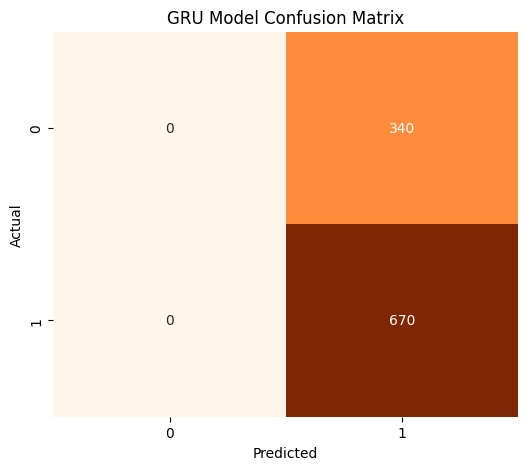

CNN + LSTM Model


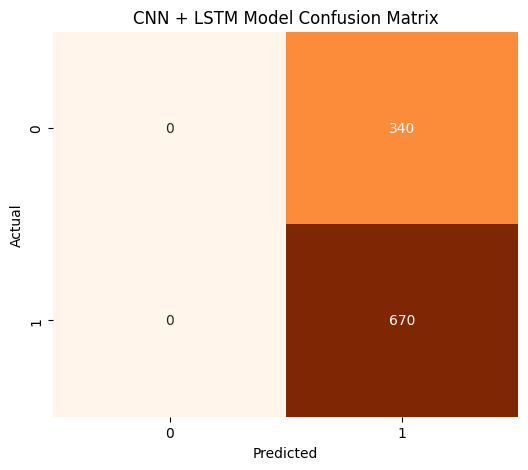

Attention-based LSTM Model


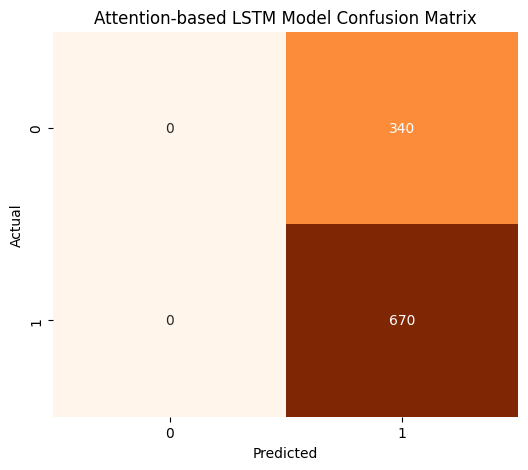

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate and plot confusion matrices for each model
print("\nConfusion Matrices:")

# GRU model
print("GRU Model")
plot_confusion_matrix(y_test_class, predictions_gru_class, "GRU Model")

# CNN + LSTM model
print("CNN + LSTM Model")
plot_confusion_matrix(y_test_class, predictions_cnn_lstm_class, "CNN + LSTM Model")

# Attention-based LSTM model
print("Attention-based LSTM Model")
plot_confusion_matrix(y_test_class, predictions_attention_class, "Attention-based LSTM Model")
